## 孔隙率数据归一化的高斯过程回归建模

#### 考虑当前高斯过程回归模型中的核函数涉及基于距离度量样本之间的相似性，且涉及高斯分布，为了消除功率和扫描速度参数的量纲的影响，加快超参数调优过程中边缘似然的收敛，将数据进行0均值，1方差，近似正太分布的归一化

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,\
ConstantKernel as c
from sklearn.gaussian_process.kernels import WhiteKernel
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.pyplot import MultipleLocator
import xlwt
import copy
import warnings

In [2]:
from pyecharts.charts import Bar3D
from pyecharts import options as opts

In [3]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [53]:
sns.set()
warnings.filterwarnings('ignore')
font1 = {
    'family': 'SimSun',
    'weight': 'bold',
    'size': 25
}
font2 = {
    'family': 'Times New Roman',
    'weight': 'normal',
    'size': 13
}
font3 = {
    'family': 'Times New Roman',
    'weight': 'normal',
    'size': 10
}

#### 读取数据

In [5]:
filepath = 'C:/Users/123456/Desktop/graduation_pro/数据/不锈钢孔隙率/不锈钢孔隙率.xlsx'
df = pd.read_excel(filepath, skiprows=2)
df.head()

,P功率（W）,V速率（mm/s）,孔隙率
0,100.0,600.0,0.0286119
1,130.0,600.0,0.00139632
2,160.0,600.0,0.00256942
3,190.0,600.0,0.00167753
4,220.0,600.0,0.0020328


In [6]:
df.columns = ['power', 'speed', 'porosity']
df.head()

,power,speed,porosity
0,100.0,600.0,0.0286119
1,130.0,600.0,0.00139632
2,160.0,600.0,0.00256942
3,190.0,600.0,0.00167753
4,220.0,600.0,0.0020328


In [7]:
df.info

<bound method DataFrame.info of     power   speed     porosity
0   100.0   600.0    0.0286119
1   130.0   600.0   0.00139632
2   160.0   600.0   0.00256942
3   190.0   600.0   0.00167753
4   220.0   600.0    0.0020328
5   250.0   600.0   0.00655269
6   280.0   600.0            无
7   310.0   600.0   0.00342794
8   340.0   600.0   0.00361515
9     NaN     NaN          NaN
10  100.0   800.0     0.105842
11  130.0   800.0   0.00784839
12  160.0   800.0   0.00149687
13  190.0   800.0   0.00228068
14  220.0   800.0   0.00179948
15  250.0   800.0   0.00158883
16  280.0   800.0   0.00323979
17  310.0   800.0   0.00281177
18  340.0   800.0   0.00573458
19    NaN     NaN          NaN
20  100.0  1000.0      0.24178
21  130.0  1000.0    0.0817946
22  160.0  1000.0    0.0129543
23  190.0  1000.0     0.001592
24  220.0  1000.0   0.00175073
25  250.0  1000.0   0.00150989
26  280.0  1000.0   0.00239966
27  310.0  1000.0   0.00296098
28  340.0  1000.0   0.00379513
29    NaN     NaN          NaN
30  100

In [8]:
# 去除缺失值
df.dropna(axis=0, inplace=True)
none_ind = df[df['porosity'] == '无'].index
df.drop(none_ind, axis=0, inplace=True)
df.shape

(52, 3)

In [9]:
# 查看数据表信息，数据类型及缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 58
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   power     52 non-null     float64
 1   speed     52 non-null     float64
 2   porosity  52 non-null     object 
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [10]:
# 孔隙率最小的点
df['porosity'] = df['porosity'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 58
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   power     52 non-null     float64
 1   speed     52 non-null     float64
 2   porosity  52 non-null     float64
dtypes: float64(3)
memory usage: 1.6 KB


In [11]:
df.reset_index(drop=True, inplace=True)
df.shape

(52, 3)

In [12]:
data = df.pivot('speed', 'power', 'porosity')
data.sort_index(ascending=False, inplace=True)
data

power,100.0,130.0,160.0,190.0,220.0,250.0,280.0,310.0,340.0
speed,,,,,,,,,
1600.0,0.530762,0.284318,0.137513,0.067189,0.025789,0.018085,0.010881,0.014774,0.014053
1400.0,0.283952,0.152425,0.082177,0.021261,0.011454,0.003870,0.001889,0.001201,NaN
1200.0,0.306176,0.126540,0.033642,0.014476,0.002790,0.000659,0.001464,0.001817,0.000441
1000.0,0.241780,0.081795,0.012954,0.001592,0.001751,0.001510,0.002400,0.002961,0.003795
800.0,0.105842,0.007848,0.001497,0.002281,0.001799,0.001589,0.003240,0.002812,0.005735
600.0,0.028612,0.001396,0.002569,0.001678,0.002033,0.006553,NaN,0.003428,0.003615


In [13]:
data1 = data.fillna(-1)
data1

power,100.0,130.0,160.0,190.0,220.0,250.0,280.0,310.0,340.0
speed,,,,,,,,,
1600.0,0.530762,0.284318,0.137513,0.067189,0.025789,0.018085,0.010881,0.014774,0.014053
1400.0,0.283952,0.152425,0.082177,0.021261,0.011454,0.003870,0.001889,0.001201,-1.000000
1200.0,0.306176,0.126540,0.033642,0.014476,0.002790,0.000659,0.001464,0.001817,0.000441
1000.0,0.241780,0.081795,0.012954,0.001592,0.001751,0.001510,0.002400,0.002961,0.003795
800.0,0.105842,0.007848,0.001497,0.002281,0.001799,0.001589,0.003240,0.002812,0.005735
600.0,0.028612,0.001396,0.002569,0.001678,0.002033,0.006553,-1.000000,0.003428,0.003615


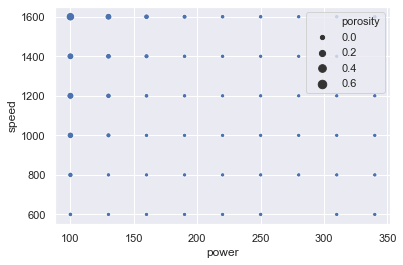

In [14]:
# 查看孔隙率的分布
sns.scatterplot(x='power', y='speed', size='porosity',\
               data=df)

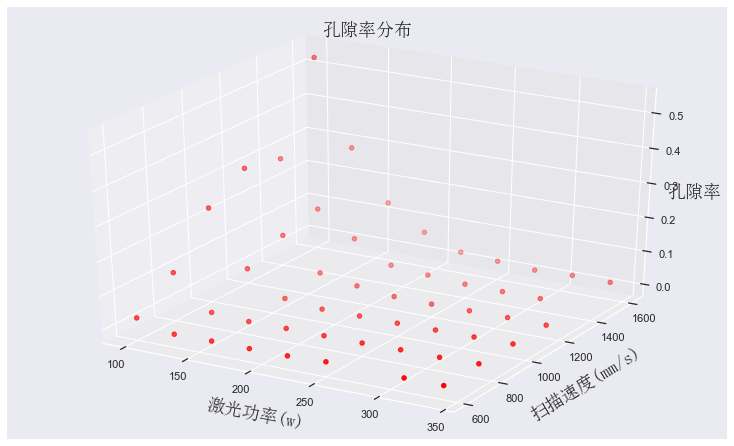

In [15]:
sns.set_style('dark')
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
# ax_obj = ax.scatter(df['power'], df['speed'],\
#            np.float16(df['porosity']))
ax_obj = ax.scatter(df['power'], df['speed'],\
           np.float16(df['porosity']), c='red')
# plt.colorbar(ax_obj, shrink=0.8)
ax.set_title('孔隙率分布', fontdict=font1)
ax.set_xlabel('\n激光功率(w)', fontdict=font1)
ax.set_ylabel('\n扫描速度(mm/s)', fontdict=font1, weight='bold')
ax.set_zlabel('孔隙率', fontdict=font1)
# plt.tick_params(labelsize=13)
plt.show()

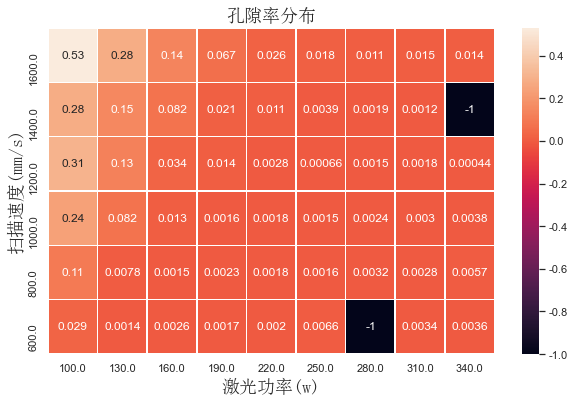

In [16]:
# 绘制颜色映射图
# df['porosity'] = df['porosity'].astype('float16')
# data = df.pivot(index='power', columns='speed', values='porosity')
f, ax = plt.subplots(figsize=(10,6))
sns.heatmap(data1, annot=True, linewidths=.5, ax=ax)
plt.title('孔隙率分布', fontdict=font1)
plt.xlabel('激光功率(w)', fontdict=font1)
plt.ylabel('扫描速度(mm/s)', fontdict=font1)
plt.show()

In [17]:
# # pyecharts可视化
# # 数据准备
# power = df['power'].tolist()
# speed = df['speed'].tolist()
# porosity = []
# for row in df.iterrows():
#     porosity.append(list(row[1]))

In [18]:
# # 可视化
# (
#     Bar3D(init_opts=opts.InitOpts(width="1600px", height="800px"))
#     .add(
#         series_name="",
#         data=porosity,
#         xaxis3d_opts=opts.Axis3DOpts(type_="value", data=power),
#         yaxis3d_opts=opts.Axis3DOpts(type_="value", data=speed),
#         zaxis3d_opts=opts.Axis3DOpts(type_="value"),
#     )
#     .set_global_opts(
#         visualmap_opts=opts.VisualMapOpts(
#             max_=0.5,
#             min_=0.000,
#             range_color=[
#                 "#313695",
#                 "#4575b4",
#                 "#74add1",
#                 "#abd9e9",
#                 "#e0f3f8",
#                 "#ffffbf",
#                 "#fee090",
#                 "#fdae61",
#                 "#f46d43",
#                 "#d73027",
#                 "#a50026",
#             ],
#         )
#     )
#     .render_notebook()
# )

In [19]:
# 数据筛选，关注低频数据，去除高频数据的影响
# 剔除9个数据
print(df.shape)
df = df[df['power'] > 100]
print(df.shape)
df

(52, 3)
(46, 3)


,power,speed,porosity
1,130.0,600.0,0.001396
2,160.0,600.0,0.002569
3,190.0,600.0,0.001678
4,220.0,600.0,0.002033
5,250.0,600.0,0.006553
6,310.0,600.0,0.003428
7,340.0,600.0,0.003615
9,130.0,800.0,0.007848
10,160.0,800.0,0.001497
11,190.0,800.0,0.002281


In [20]:
df.reset_index(inplace=True, drop=True)
df

,power,speed,porosity
0,130.0,600.0,0.001396
1,160.0,600.0,0.002569
2,190.0,600.0,0.001678
3,220.0,600.0,0.002033
4,250.0,600.0,0.006553
5,310.0,600.0,0.003428
6,340.0,600.0,0.003615
7,130.0,800.0,0.007848
8,160.0,800.0,0.001497
9,190.0,800.0,0.002281


In [21]:
type(df['power'])

pandas.core.series.Series

In [22]:
# 功率和扫描速度归一化standarization
scaler_X = StandardScaler().fit(df[['power', 'speed']])
scaler_X.mean_
new_X = scaler_X.transform(df[['power', 'speed']])

In [23]:
scaler_Y = StandardScaler().fit(df[['porosity']])
scaler_Y.mean_
scaler_Y.scale_
new_Y = scaler_Y.transform(df[['porosity']])

In [24]:
new_X
new_Y[0][0]

-0.4580175225117186

In [25]:
new_X[:,0]

array([-1.494209  , -1.05360891, -0.61300882, -0.17240873,  0.26819136,
        1.14939154,  1.58999163, -1.494209  , -1.05360891, -0.61300882,
       -0.17240873,  0.26819136,  0.70879145,  1.14939154,  1.58999163,
       -1.494209  , -1.05360891, -0.61300882, -0.17240873,  0.26819136,
        0.70879145,  1.14939154,  1.58999163, -1.494209  , -1.05360891,
       -0.61300882, -0.17240873,  0.26819136,  0.70879145,  1.14939154,
        1.58999163, -1.494209  , -1.05360891, -0.61300882, -0.17240873,
        0.26819136,  0.70879145,  1.14939154, -1.494209  , -1.05360891,
       -0.61300882, -0.17240873,  0.26819136,  0.70879145,  1.14939154,
        1.58999163])

In [26]:
# 标准化之后的数据表
new_df = pd.DataFrame()
new_df['power'] = new_X[:, 0].ravel()
new_df['speed'] = new_X[:, 1].ravel()
new_df['porosity'] = new_Y.ravel()

In [27]:
new_df

,power,speed,porosity
0,-1.494209,-1.491599,-0.458018
1,-1.053609,-1.491599,-0.435976
2,-0.613009,-1.491599,-0.452734
3,-0.172409,-1.491599,-0.446058
4,0.268191,-1.491599,-0.361132
5,1.149392,-1.491599,-0.419844
6,1.589992,-1.491599,-0.416327
7,-1.494209,-0.900103,-0.336786
8,-1.053609,-0.900103,-0.456128
9,-0.613009,-0.900103,-0.441401


Text(0.5, 0, 'speed')

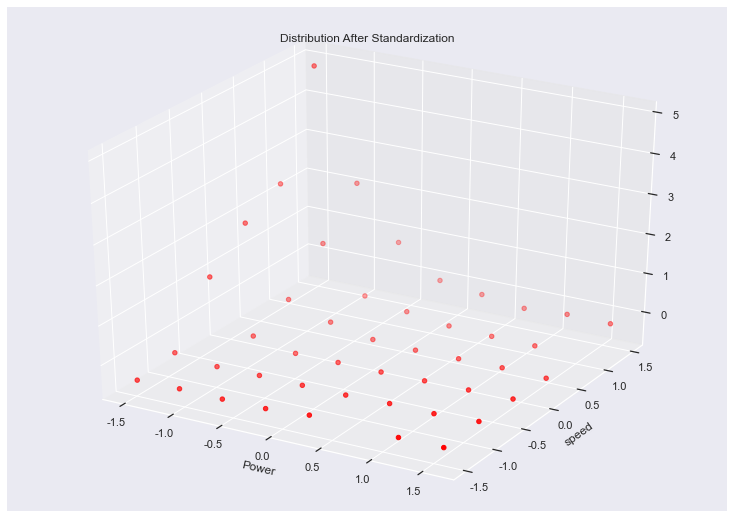

In [28]:
# 查看标准化后的数据的分布
fig = plt.figure(figsize=(10, 7))
ax = Axes3D(fig)
ax.scatter(new_df['power'], new_df['speed'],\
           new_df['porosity'], c='red')
ax.set_title('Distribution After Standardization')
ax.set_xlabel('Power')
ax.set_ylabel('speed')

### 高斯过程回归

In [29]:
# # 核函数，常数核和高斯核，常数核可缩放均值
# kernel = c(1.0, (1e-4, 10)) * RBF(length_scale=100,\
#                                     length_scale_bounds=(1e-4, 1e4))

In [30]:
# # 构建回归器，优化10轮，alpha值设置为0
# reg = GaussianProcessRegressor(kernel=kernel,\
#                                n_restarts_optimizer=10,\
#                                alpha=0)
# reg.fit(df[['power', 'speed']], df['porosity'])

In [31]:
# reg.kernel_.theta
# # reg.kernel_
# reg.log_marginal_likelihood(reg.kernel_.theta)
# # reg.get_params()
# reg.log_marginal_likelihood(reg.kernel.theta)

In [32]:
# constant_value = reg.kernel_.k1.constant_value
# length_scale = reg.kernel_.k2.length_scale
# print('optimized length_scale: {}\n optimized constant_value: {}'\
#      .format(length_scale, constant_value))

In [33]:
# # 创建作图的网格测试数据
# p_min, p_max = df['power'].min(),\
# df['power'].max()
# s_min, s_max = df['speed'].min(),\
# df['speed'].max()
# print(p_max, p_min)
# print(s_max, s_min)
# p_set, s_set = np.meshgrid(np.arange(p_min, p_max, 1),\
#                           np.arange(s_min, s_max, 1))

In [34]:
# # 查看网格数据输出结果并返回标准差
# output, err = reg.predict(np.c_[p_set.ravel(), s_set.ravel()]\
#                          , return_std=True)
# output, err = output.reshape(p_set.shape), err.reshape(p_set.shape)
# sigma = np.sum(reg.predict(df[['power', 'speed']],\
#                           return_std=True)[1])

In [35]:
# 上下置信区间
# up, down = output * (1 + 1.96*err), output * (1 - 1.96*err)

In [36]:
# output

In [37]:
# output_data = pd.DataFrame(columns=['power', 'speed', 'porosity'])
# output_data['power'] = p_set.ravel()
# output_data['speed'] = s_set.ravel()
# output_data['porosity'] = output.ravel()
# output_data.shape

In [38]:
# # 拟合的决定系数
# reg.score(df[['power', 'speed']], df['porosity'])

In [39]:
# plt.figure()
# theta0 = np.logspace(-2, 3, 49)
# theta1 = np.logspace(-2, 0, 50)
# Theta0, Theta1 = np.meshgrid(theta0, theta1)
# LML = [[reg.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))\
#         for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
# LML = np.array(LML).T
# vmin, vmax = (-LML).min(), (-LML).max()
# vmin = 20
# vmax = 50
# level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
# plt.contour(Theta0, Theta1, -LML, \
#             levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
# plt.colorbar()
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Length-scale")
# plt.ylabel("Noise-level")
# plt.title("Log-marginal-likelihood")
# plt.tight_layout()
# plt.show()

In [40]:
# output_pivot = output_data.pivot('power', 'speed', 'porosity')
# f, ax = plt.subplots(figsize=(30,15))
# sns.heatmap(output_pivot, ax=ax)
# ax.set_title('constant kernel heatmap', fontsize=30)

In [41]:
# # 作图
# fig = plt.figure(figsize=(60,30))
# ax1 = fig.add_subplot(111, projection='3d')
# surf = ax1.plot_wireframe(p_set, s_set, output, rstride=10,\
#                           cstride=2, antialiased=True)
# # 上界置信区间
# # surf_u = ax1.plot_wireframe(p_set, s_set, up, colors=\
# #                             'lightgreen', linewidths=1,\
# #                             rstride=10, cstride=2, antialiased=True)
# # 下界置信区间
# # surf_d = ax1.plot_wireframe(p_set, s_set, down, colors=\
# #                             'lightgreen', linewidths=1,\
# #                             rstride=10, cstride=2, antialiased=True)
# ax1.scatter(df['power'], df['speed'],\
#             np.float16(df['porosity']), c='red', s=50)
# ax1.set_title('porosity of different parameters\nconstant kernel', fontsize=30)
# ax1.set_xlabel('power', fontsize=30)
# ax1.set_ylabel('speed', fontsize=30)
# plt.tick_params(labelsize=20)
# plt.show()

In [42]:
# 绘制等高线图
# plt.figure(figsize=(15,7))
# plt.contourf(p_set, s_set, output, offset=0, cmap=cm.coolwarm, alpha=0.6)
# plt.colorbar()
# plt.title('porosity contour distribution')
# plt.xlabel('power')
# plt.ylabel('speed')

#### 带噪声的核函数，高斯核加上白噪声核

In [43]:
kernel_1 = 1.0 * RBF(length_scale=10,\
                   length_scale_bounds=(1e-4, 1e4)) +\
WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-10, 1e+1))

In [44]:
# 构建回归器，优化10轮，噪声水平设置为零
reg_1 = GaussianProcessRegressor(kernel=kernel_1,\
                               n_restarts_optimizer=15,\
                               alpha=0, random_state=42)
reg_1.fit(new_df[['power', 'speed']], new_df['porosity'])

GaussianProcessRegressor(alpha=0, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=0.001),
                         n_restarts_optimizer=15, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=42)

In [45]:
theta = reg_1.kernel_.k1.theta
noise_level = reg_1.kernel_.k2.noise_level
print('optimized theta: {}\n optimized noise_level: {}'\
     .format(theta, noise_level))

optimized theta: [3.50028248 0.69888929]
 optimized noise_level: 0.026605143076628774


In [46]:
reg_1.get_params()
reg_1.log_marginal_likelihood()

-20.805681240285452

In [47]:
reg_1.log_marginal_likelihood_value_

-20.805681240285452

In [48]:
# 创建作图的网格测试数据
p_min, p_max = new_df['power'].min(),\
new_df['power'].max()
s_min, s_max = new_df['speed'].min(),\
new_df['speed'].max()
print(p_max, p_min)
print(s_max, s_min)
p_set1, s_set1 = np.meshgrid(np.arange(p_min, p_max + 0.35, 0.01),\
                          np.arange(s_min, s_max + 0.35, 0.01))

1.5899916334671118 -1.494209004944996
1.465881824639873 -1.491599049633555


In [49]:
p_set1.shape

(331, 344)

In [50]:
# 测试数据全部作为训练数据的模型评估
test_predict = reg_1.predict(new_df[['power', 'speed']])

In [51]:
test_predict_inver = scaler_Y.inverse_transform(test_predict)
test_predict_inver

array([-3.18837890e-04, -2.68523023e-03,  9.21880676e-04,  5.05314375e-03,
        6.07168303e-03,  2.15743386e-03,  5.34886943e-03,  2.40484286e-02,
        4.00742020e-03, -1.48423373e-03,  5.91301021e-04,  3.37742554e-03,
        3.52231595e-03,  2.27588150e-03,  3.94877324e-03,  6.32763431e-02,
        2.09342698e-02,  2.46728992e-03, -1.07010885e-04,  3.09579613e-03,
        4.83257528e-03,  3.43724991e-03,  2.17995599e-03,  1.11931114e-01,
        4.40550571e-02,  8.78715523e-03, -1.64595061e-03,  2.35052668e-04,
        3.47616630e-03,  2.99482966e-03,  1.28626620e-04,  1.76113929e-01,
        8.17447378e-02,  2.60333807e-02,  3.16886863e-03,  4.69952531e-05,
        3.18749636e-03,  4.26058858e-03,  2.64903981e-01,  1.46733523e-01,
        6.85537680e-02,  2.82574837e-02,  1.45060973e-02,  1.33318447e-02,
        1.41952964e-02,  1.28991664e-02])

In [55]:
mae = mean_absolute_error(df['porosity'], test_predict_inver)
mae

0.004398056520589558

In [41]:
# 查看网格数据输出结果并返回标准差
output1, std = reg_1.predict(np.c_[p_set1.ravel(), s_set1.ravel()]\
                         , return_std=True)
output1, std = output1.reshape(p_set1.shape), std.reshape(p_set1.shape)
# sigma = np.sum(reg_1.predict(df[['power', 'speed']],\
#                           return_std=True)[1])

In [43]:
new_output = reg_1.predict(new_df[['power', 'speed']],\
                           return_std=False)
new_output

array([-0.49024458, -0.53470801, -0.46693205, -0.38930751, -0.37016962,
       -0.44371657, -0.38375096, -0.03239481, -0.40895618, -0.51214184,
       -0.47314349, -0.42079349, -0.41807106, -0.441491  , -0.41005813,
        0.70467974, -0.09090843, -0.43789452, -0.48626445, -0.42608517,
       -0.39345189, -0.41966941, -0.44329339,  1.6188806 ,  0.34352058,
       -0.31914714, -0.51518042, -0.47983723, -0.41893819, -0.42798229,
       -0.48183693,  2.82484628,  1.05169241,  0.00490153, -0.42471218,
       -0.48337075, -0.42436217, -0.40419926,  4.49317069,  2.27280191,
        0.80384013,  0.04669141, -0.21169084, -0.23375451, -0.21753065,
       -0.24188434])

In [44]:
# 上下置信区间
up, down = output1 * (1 + 1.96*std), output1 * (1 - 1.96*std)

In [45]:
output1

array([[-0.49024458, -0.49319519, -0.49604349, ..., -0.24004757,
        -0.23416351, -0.22819236],
       [-0.48598869, -0.48907572, -0.49205923, ..., -0.24082451,
        -0.23494489, -0.22897812],
       [-0.48159357, -0.48481776, -0.48793723, ..., -0.24160806,
        -0.23573347, -0.22977168],
       ...,
       [ 5.58623147,  5.52487362,  5.46377271, ..., -0.07048213,
        -0.07133876, -0.07218391],
       [ 5.62147814,  5.56003044,  5.49883828, ..., -0.06332071,
        -0.06417893, -0.06502584],
       [ 5.65678107,  5.59524503,  5.53396311, ..., -0.05611361,
        -0.0569735 , -0.05782226]])

In [46]:
# 写入预测数据

In [47]:
# ucb_data.sort_values(by='porosity', inplace=True)
# (a, b) = ucb_data.shape
# save_path = 'C:/Users/123456/Desktop/graduation_pro/数据/\
# 不锈钢孔隙率/ucb_result.xls'
# workbook = xlwt.Workbook(encoding='utf-8')
# sheet = workbook.add_sheet('ucb')
# columns = ['ucb', 'power', 'speed', 'porosity']
# for i in range(b):
#     sheet.write(0, i, columns[i])
# for i in range(1, a + 1):
#     for j in range(b):
#         sheet.write(i, j, ucb_data.iloc[i-1, j])
# workbook.save(save_path)
# print('Done!')

In [48]:
# 拟合的决定系数
reg_1.score(new_df[['power', 'speed']], new_df['porosity'])

0.9822963639319369

In [49]:
output1_data = pd.DataFrame(columns=['power', 'speed', 'porosity'])
output1_data['power'] = p_set1.ravel()
output1_data['speed'] = s_set1.ravel()
output1_data['porosity'] = output1.ravel()
output1_data.shape

(113864, 3)

In [50]:
# 预测数据反归一化
scale_X = scaler_X.inverse_transform(output1_data[['power', 'speed']])
scale_Y = scaler_Y.inverse_transform(output1_data[['porosity']])

In [52]:
new_porosity = scaler_Y.inverse_transform(new_output.ravel())
new_porosity

array([-3.18837890e-04, -2.68523023e-03,  9.21880676e-04,  5.05314375e-03,
        6.07168303e-03,  2.15743386e-03,  5.34886943e-03,  2.40484286e-02,
        4.00742020e-03, -1.48423373e-03,  5.91301021e-04,  3.37742554e-03,
        3.52231595e-03,  2.27588150e-03,  3.94877324e-03,  6.32763431e-02,
        2.09342698e-02,  2.46728992e-03, -1.07010885e-04,  3.09579613e-03,
        4.83257528e-03,  3.43724991e-03,  2.17995599e-03,  1.11931114e-01,
        4.40550571e-02,  8.78715523e-03, -1.64595061e-03,  2.35052668e-04,
        3.47616630e-03,  2.99482966e-03,  1.28626620e-04,  1.76113929e-01,
        8.17447378e-02,  2.60333807e-02,  3.16886863e-03,  4.69952531e-05,
        3.18749636e-03,  4.26058858e-03,  2.64903981e-01,  1.46733523e-01,
        6.85537680e-02,  2.82574837e-02,  1.45060973e-02,  1.33318447e-02,
        1.41952964e-02,  1.28991664e-02])

In [46]:
new_output = pd.DataFrame(columns=['power', 'speed', 'porosity'])
new_output['power'] = scale_X[:, 0].ravel()
new_output['speed'] = scale_X[:, 1].ravel()
new_output['porosity'] = scale_Y.ravel()

In [47]:
p_inverse = scale_X[:, 0].reshape(p_set1.shape)
s_inverse = scale_X[:, 1].reshape(s_set1.shape)
out_inverse = scale_Y.reshape(p_set1.shape)

Text(0.5, 1.0, 'noise kernel heatmap')

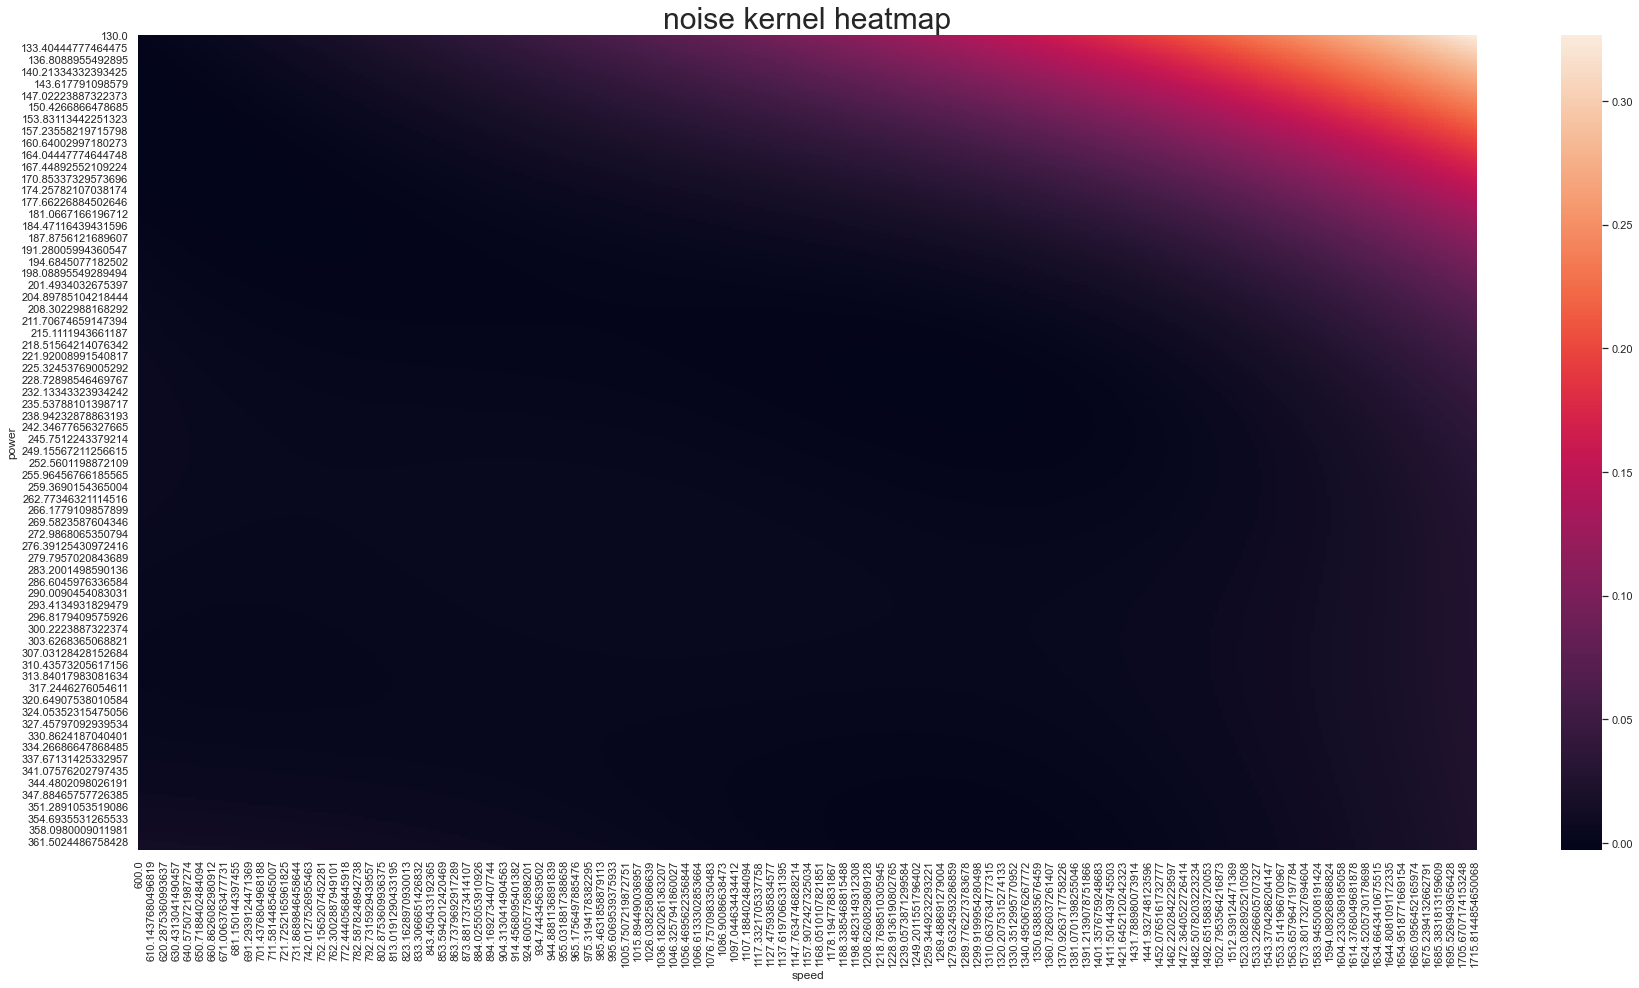

In [48]:
output_pivot = new_output.pivot('power', 'speed', 'porosity')
f, ax = plt.subplots(figsize=(30,15))
sns.heatmap(output_pivot, ax=ax)
ax.set_title('noise kernel heatmap', fontsize=30)

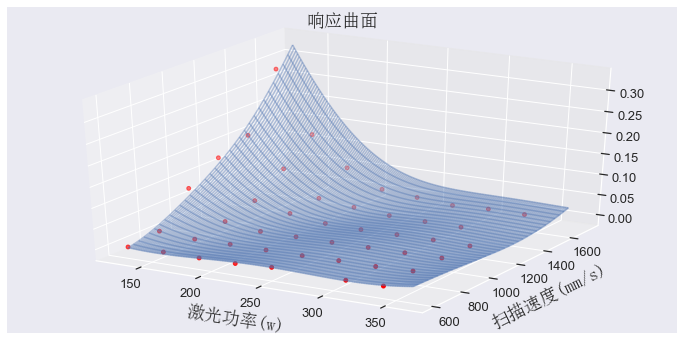

In [49]:
# 作图
sns.set_style('dark')
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111, projection='3d')
surf = ax1.plot_wireframe(p_inverse, s_inverse, out_inverse,\
                          rstride=10, cstride=2,\
                          antialiased=True, alpha=0.4)
# 上界置信区间
# surf_u = ax1.plot_wireframe(p_set, s_set, up, colors=\
#                             'lightgreen', linewidths=1,\
#                             rstride=10, cstride=2, antialiased=True)
# 下界置信区间
# surf_d = ax1.plot_wireframe(p_set, s_set, down, colors=\
#                             'lightgreen', linewidths=1,\
#                             rstride=10, cstride=2, antialiased=True)
ax1.scatter(df['power'], df['speed'],\
            np.float16(df['porosity']), c='red', s=15)
ax1.set_title('响应曲面', fontdict=font1)
ax1.set_xlabel('\n激光功率(w)', fontdict=font1)
ax1.set_ylabel('\n扫描速度(mm/s)', fontdict=font1)
plt.tick_params(labelsize=13)
plt.show()

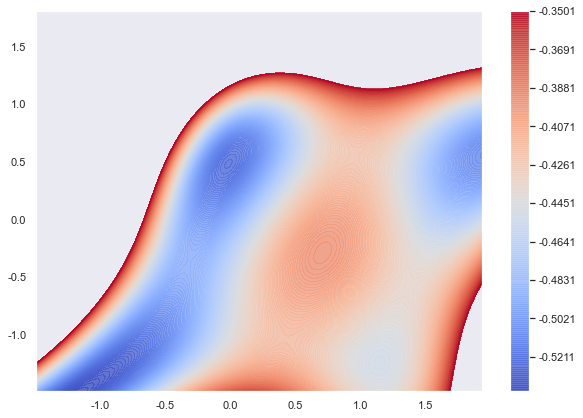

In [50]:
# 绘制归一化预测的等高线图
fig = plt.figure(figsize=(10, 7))
plt.contourf(p_set1, s_set1, output1,
             np.arange(output1.min(), -0.35, 0.001), offset=0,\
            cmap=cm.coolwarm, alpha=0.8)
plt.colorbar()
plt.show()

In [51]:
# sns.set_style('white')
# font1 = {
#     'family': 'Times New Roman',
#     'weight': 'bold',
#     'size': 30
# }
# font2 = {
#     'family': 'Times New Roman',
#     'weight': 'normal',
#     'size': 15
# }
# font3 = {
#     'family': 'Times New Roman',
#     'weight': 'normal',
#     'size': 30
# }

In [52]:
# df.columns = ['power', 'speed', 'Porosity']

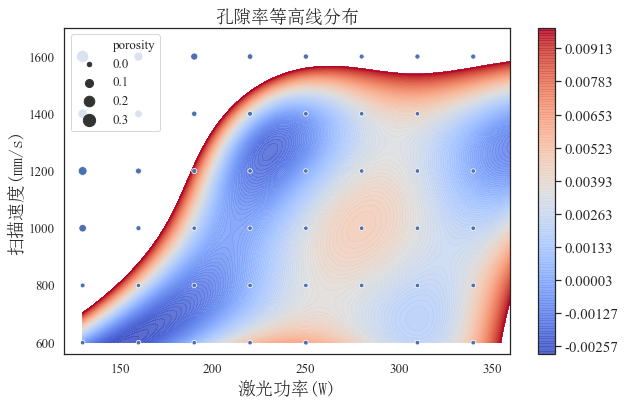

In [53]:
# 绘制等高线图
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,6))
plt.contourf(p_inverse, s_inverse, out_inverse,\
             np.arange(out_inverse.min(), 0.01, 0.0001),\
                   offset=0, cmap=cm.coolwarm,\
             alpha=0.85)
cb = plt.colorbar()
cb_labels = cb.ax.yaxis.get_ticklabels()
for cb_label in cb_labels:
    cb_label.set_family('Times New Roman')
    cb_label.set_fontsize(15)
plt.title('孔隙率等高线分布', fontdict=font1)
plt.xlabel('激光功率(w)', fontdict=font1)
plt.ylabel('扫描速度(mm/s)', fontdict=font1)
plt.tick_params(labelsize=13)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
x_tick = [100 + 50*i for i in range(1, 6)]
y_tick = [600 + 200*j for j in range(6)]
plt.xticks(x_tick, fontsize=24)
plt.yticks(y_tick, fontsize=24)
plt.tick_params(labelsize=13)
plt.xlim(120, 360)
plt.ylim(560, 1700)
sp = sns.scatterplot(x='power', y='speed', size='porosity',\
                          data=df, sizes=(20, 150))
plt.xlabel('激光功率(W)', fontdict=font1)
plt.ylabel('扫描速度(mm/s)', fontdict=font1)
plt.legend(loc='upper left', prop=font2)
# sp.legend('孔隙率', loc='upper left', prop=font1)
plt.show()

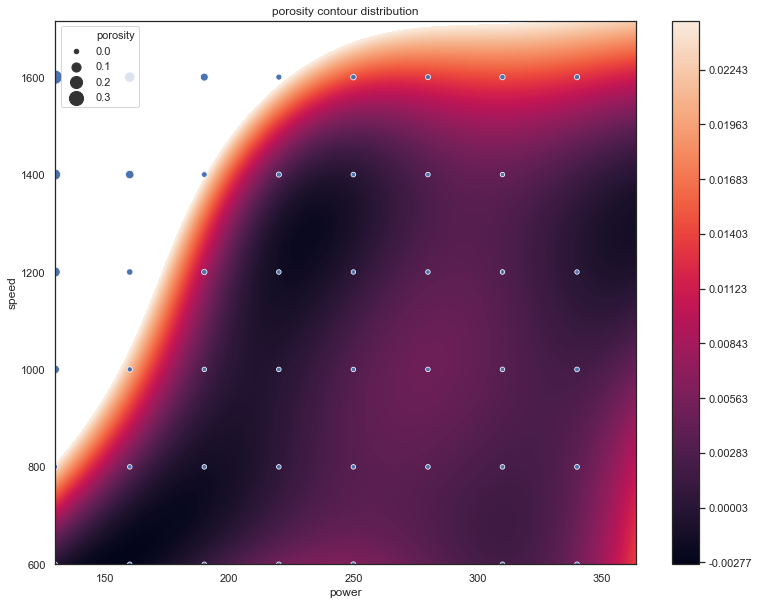

In [54]:
# 绘制等高线图
fig1 = plt.figure(figsize=(13,10))
# plt.scatter(x=df['power'], y=df['speed'],\
#             s=[i**2 for i in df['porosity']])
con = plt.contourf(p_inverse, s_inverse,\
             out_inverse, np.arange(out_inverse.min(), 0.025, 0.0001))
#                    offset=0, cmap=cm.coolwarm,\
#              alpha=0.85)
plt.colorbar()
plt.title('porosity contour distribution')
plt.xlabel('Laser Power(W)')
plt.ylabel('Scanning Speed(mm/s)')
# x_tick = [100 + 50*i for i in range(1, 6)]
# y_tick = [600 + 200*j for j in range(6)]
# plt.xticks(x_tick, fontsize=24)
# plt.yticks(y_tick, fontsize=24)
# plt.xlim(120, 360)
# plt.ylim(560, 1700)
sns.scatterplot(x='power', y='speed', size='porosity',\
               data=df, sizes=(20, 200))
# plt.xlabel('Laser Power(W)', fontdict=font1)
# plt.ylabel('Scanning Speed(mm/s)', fontdict=font1)
plt.legend(loc='upper left')
plt.show()

In [55]:
out_inverse.min()

-0.002867004683483599

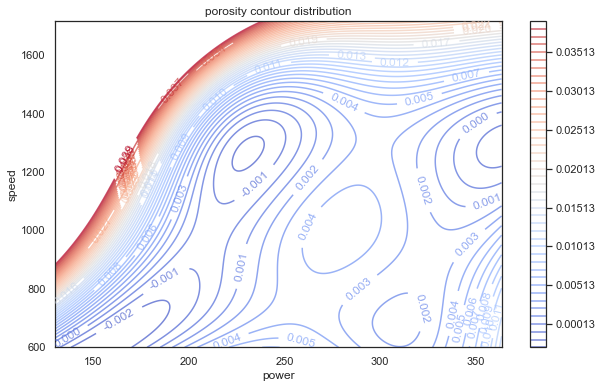

In [56]:
# 绘制等高线图
plt.figure(figsize=(10,6))
contour = plt.contour(p_inverse, s_inverse, out_inverse,\
                      np.arange(out_inverse.min(), 0.04, 0.001),
                      off_set=0, cmap=cm.coolwarm, alpha=0.7)
plt.colorbar()
plt.title('porosity contour distribution')
plt.xlabel('power')
plt.ylabel('speed')
plt.clabel(contour)
plt.show()

In [57]:
# 筛选绘制组合图的数据
df_chart = df[df['porosity'] < 0.03]
output1_copy = copy.deepcopy(out_inverse)
vmin = out_inverse.min()
vmin

-0.002867004683483599

In [58]:
out_inverse[out_inverse > 0.025] = np.nan

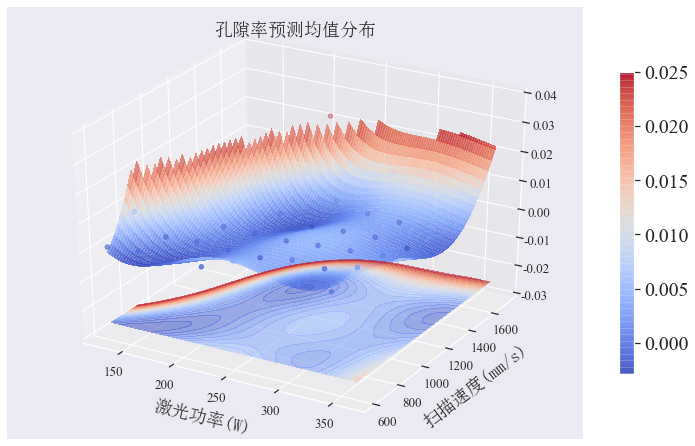

In [59]:
# 绘制surface, contourf, scatter结合图
sns.set(
    style='darkgrid',
    font='Times New Roman',
    font_scale=1.8
)
fig_conbine = plt.figure(figsize=(10, 6))
ax = Axes3D(fig_conbine)
vmax = 0.025
surface = ax.plot_surface(p_inverse, s_inverse, out_inverse, cmap=cm.coolwarm,\
                antialiased=False, vmin=vmin, vmax=vmax,\
                rstride=8, cstride=3, linewidth=0, alpha=0.7)
ax.scatter(df_chart['power'], df_chart['speed'],\
           df_chart['porosity'], c=df_chart['porosity'],\
           cmap=cm.coolwarm)
ax.contourf(p_inverse, s_inverse, out_inverse,\
            np.arange(output1_copy.min(), 0.025, 0.001), zdir='output1_copy',\
            offset=-0.025, alpha=0.55, cmap=cm.coolwarm)
plt.colorbar(surface, shrink=0.7)
ax.set_zlim(-0.03, 0.04)
# ax.set_xlabel('\n\nLaser Power (W)', fontdict=font1)
# ax.set_ylabel('\nScanning Speed (mm/s)', fontdict=font1)
# ax.set_title('Porosity Prediction', fontdict=font1)
ax.set_xlabel('\n激光功率(W)', fontdict=font1)
ax.set_ylabel('\n扫描速度(mm/s)', fontdict=font1)
ax.set_title('孔隙率预测均值分布', fontdict=font1)
plt.tick_params(labelsize=13)
plt.show()

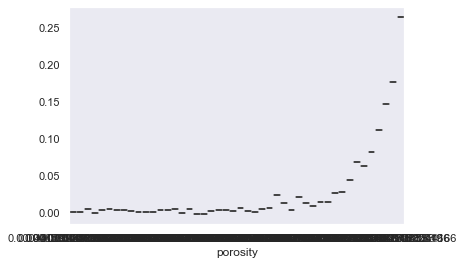

In [53]:
# 模型评估箱型图绘制
sns.boxplot(df['porosity'], new_porosity.ravel())

In [60]:
# UCB值计算
ucb_1 = out_inverse + 0.01*std
ucb_2 = out_inverse + 0.1*std
ucb_3 = out_inverse + 1*std
ucb_4 = out_inverse + 10*std

In [61]:
output1_data = pd.DataFrame(columns=['power', 'speed', 'porosity'])
output1_data['power'] = p_inverse.ravel()
output1_data['speed'] = s_inverse.ravel()
output1_data['porosity'] = out_inverse.ravel()
output1_data['ucb-0.01'] = ucb_1.ravel()
output1_data['ucb-0.1'] = ucb_2.ravel()
output1_data['ucb-1'] = ucb_3.ravel()
output1_data['ucb-10'] = ucb_4.ravel()
output1_data.shape

(113864, 7)

In [62]:
a = (p_inverse.min() + p_inverse.max())/2
b = (s_inverse.min() + s_inverse.max())/2

In [63]:
a += 30
b = 1000

In [64]:
output1.shape

(331, 344)

In [65]:
# ucb分区选点,划分成四个区域
temp1 = output1_data[(output1_data['power'] <= a) &\
                    (output1_data['speed'] <= b)]
temp2 = output1_data[(output1_data['power'] > a) &\
                    (output1_data['speed'] <= b)]
temp3 = output1_data[(output1_data['power'] <= a) &\
                    (output1_data['speed'] > b)]
temp4 = output1_data[(output1_data['power'] > a) &\
                    (output1_data['speed'] > b)]

In [66]:
# 每个区域每个β值选两个点
ucb_res = pd.DataFrame(columns=['power', 'speed', 'porosity', 'ucb'])
temp = [temp1, temp2, temp3, temp4]
ucb = ['ucb-0.01', 'ucb-0.1', 'ucb-1', 'ucb-10']
k = 2
for t in temp:
    for u in ucb:
        sort_data = t.sort_values(by=u, ascending=True)
        filter_data = sort_data[['power', 'speed', 'porosity',\
                                 u]].iloc[0:k]
        index = [u, u]
        filter_data.index = index
        filter_data.columns = ucb_res.columns
        ucb_res = pd.concat([ucb_res, filter_data])

In [67]:
ucb_res

,power,speed,porosity,ucb
ucb-0.01,153.150245,600.000000,-0.002867,-0.000947
ucb-0.01,153.831134,600.000000,-0.002865,-0.000946
ucb-0.1,166.087146,654.100096,-0.002626,0.015769
ucb-0.1,165.406257,650.718840,-0.002642,0.015770
ucb-1,212.387636,998.988210,-0.000383,0.177026
ucb-1,211.706747,998.988210,-0.000386,0.177026
ucb-10,213.068526,998.988210,-0.000377,1.773696
ucb-10,213.749415,998.988210,-0.000366,1.773697
ucb-0.01,310.435732,687.912656,0.001745,0.003603
ucb-0.01,310.435732,684.531400,0.001744,0.003603


In [68]:
ucb_data = ucb_res.drop_duplicates(subset=['power', 'speed'], keep='first',\
                       )
ucb_data['ucbβ'] = ucb_data.index
ucb_data = ucb_data[['ucbβ', 'power', 'speed', 'porosity', 'ucb']]
ucb_data.shape

(32, 5)

In [69]:
ucb_data

,ucbβ,power,speed,porosity,ucb
ucb-0.01,ucb-0.01,153.150245,600.000000,-0.002867,-0.000947
ucb-0.01,ucb-0.01,153.831134,600.000000,-0.002865,-0.000946
ucb-0.1,ucb-0.1,166.087146,654.100096,-0.002626,0.015769
ucb-0.1,ucb-0.1,165.406257,650.718840,-0.002642,0.015770
ucb-1,ucb-1,212.387636,998.988210,-0.000383,0.177026
ucb-1,ucb-1,211.706747,998.988210,-0.000386,0.177026
ucb-10,ucb-10,213.068526,998.988210,-0.000377,1.773696
ucb-10,ucb-10,213.749415,998.988210,-0.000366,1.773697
ucb-0.01,ucb-0.01,310.435732,687.912656,0.001745,0.003603
ucb-0.01,ucb-0.01,310.435732,684.531400,0.001744,0.003603


### 写入预测数据

In [138]:
save_path = 'C:/Users/123456/Desktop/graduation_pro/数据/\
不锈钢孔隙率新/porosity_standard_ucb.xls'
(a, b) = ucb_data.shape
work_book = xlwt.Workbook(encoding='utf-8')
sheet1 = work_book.add_sheet('porosity_ucb')
columns = list(ucb_data.columns)
for i in range(b):
    sheet1.write(0, i, columns[i])
for j in range(0, a):
    for k in range(b):
        sheet1.write(j+1, k, ucb_data.iloc[j, k])
work_book.save(save_path)
print('Done!')

Done!


-43.51074361585333
-135614.16755876798


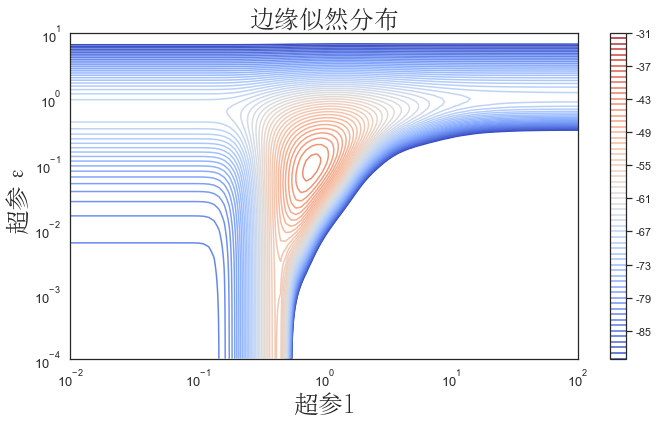

In [54]:
sns.set_style('white')
plt.figure(figsize=(10, 6))
theta0 = np.logspace(-2, 2, 100)
theta1 = np.logspace(-4, 1, 100)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[reg_1.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))\
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T
vmin, vmax = (LML).min(), (LML).max()
# vmax = 50
print(vmax)
print(vmin)
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
# plt.contour(Theta0, Theta1, LML,\
#             levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.contour(Theta0, Theta1, LML, np.arange(-90, -30, 1),\
           cmap=cm.coolwarm)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("超参l", fontdict=font1)
plt.ylabel("超参ε", fontdict=font1)
plt.title("边缘似然分布", fontdict=font1)
plt.tight_layout()
plt.tick_params(labelsize=13)
plt.show()

In [70]:
ucb_data

,ucbβ,power,speed,porosity,ucb
ucb-0.01,ucb-0.01,153.150245,600.000000,-0.002867,-0.000947
ucb-0.01,ucb-0.01,153.831134,600.000000,-0.002865,-0.000946
ucb-0.1,ucb-0.1,166.087146,654.100096,-0.002626,0.015769
ucb-0.1,ucb-0.1,165.406257,650.718840,-0.002642,0.015770
ucb-1,ucb-1,212.387636,998.988210,-0.000383,0.177026
ucb-1,ucb-1,211.706747,998.988210,-0.000386,0.177026
ucb-10,ucb-10,213.068526,998.988210,-0.000377,1.773696
ucb-10,ucb-10,213.749415,998.988210,-0.000366,1.773697
ucb-0.01,ucb-0.01,310.435732,687.912656,0.001745,0.003603
ucb-0.01,ucb-0.01,310.435732,684.531400,0.001744,0.003603


In [71]:
output1_copy.min()

-0.002867004683483599

In [75]:
# 画线
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(11):
    x1.append(a)
    y1.append(600 + 110*i)
    x2.append(100 + 26*i)
    y2.append(b)

In [82]:
a,b

(276.7725586703148, 1000)

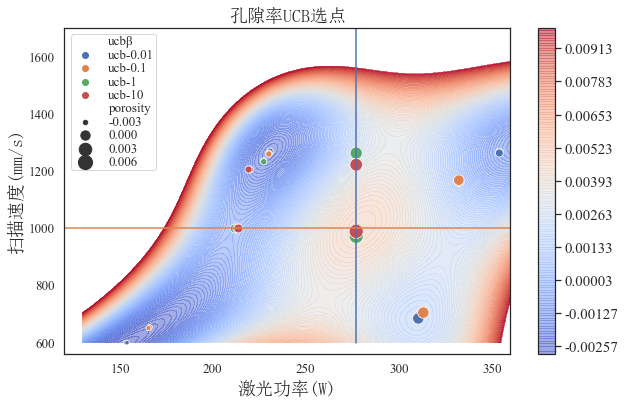

In [81]:
# 绘制等高线图
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,6))
plt.contourf(p_inverse, s_inverse, out_inverse,\
             np.arange(output1_copy.min(), 0.01, 0.0001),\
                   offset=0, cmap=cm.coolwarm, alpha=0.5)
cb = plt.colorbar()
cb_labels = cb.ax.yaxis.get_ticklabels()
for cb_label in cb_labels:
    cb_label.set_family('Times New Roman')
    cb_label.set_fontsize(15)
plt.title('孔隙率UCB选点', fontdict=font1)
plt.xlabel('Laser Power (W)', fontdict=font1)
plt.ylabel('Scanning Speed (mm/s)', fontdict=font1)
plt.tick_params(labelsize=13)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
x_tick = [100 + 50*i for i in range(1, 6)]
y_tick = [600 + 200*j for j in range(6)]
plt.xticks(x_tick, fontsize=13)
plt.yticks(y_tick, fontsize=13)
plt.xlim(120, 360)
plt.ylim(560, 1700)
p2 = sns.scatterplot(x='power', y='speed', size='porosity',\
                hue='ucbβ', data=ucb_data, sizes=(20, 200),\
                markers='*')
# sns.scatterplot(x='power', y='speed', size='porosity',\
#                           data=df, sizes=(20, 200))
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.xlabel('激光功率(W)', fontdict=font1)
plt.ylabel('扫描速度(mm/s)', fontdict=font1)
p2.legend(loc='upper left', prop=font2, labelspacing=0.1,\
         borderpad=0.1)
plt.tick_params(labelsize=13)
plt.show()

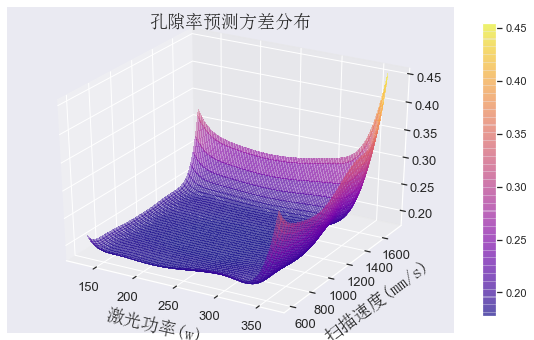

In [79]:
# 误差曲面
sns.set_style('dark')
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')
# surf = ax1.plot_wireframe(p_inverse, s_inverse, std, rstride=10,\
#                           cstride=2, antialiased=True)
vmin, vmax = std.min(), std.max()
surface = ax1.plot_surface(p_inverse, s_inverse, std,\
                           cmap=cm.plasma, antialiased=False, vmin=vmin, vmax=vmax,\
                rstride=8, cstride=3, linewidth=0, alpha=0.4)
ax1.set_title('孔隙率预测方差分布', fontdict=font1)
ax1.set_xlabel('\n激光功率(w)', fontdict=font1)
ax1.set_ylabel('\n扫描速度(mm/s)', fontdict=font1)
plt.colorbar(surface, shrink=0.9)
plt.tick_params(labelsize=13)
plt.show()

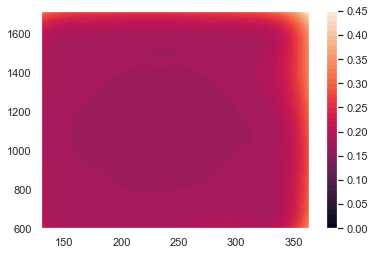

In [315]:
plt.contourf(p_inverse, s_inverse, std, np.arange(0, std.max(), 0.01))
plt.colorbar()
plt.show()

In [235]:
std.min()

0.17731831393238018